In [ ]:
!pip install opencv-python numpy matplotlib moviepy

In [ ]:
#source:https://www.geeksforgeeks.org/opencv-real-time-road-lane-detection/
import numpy as np
import pandas as pd
import cv2
#from google.colab.patches import cv2_imshow # this used only in google colab environment not in local juypter
import matplotlib.pyplot as plt
#Import everything needed to edit/save/watch video clips
from moviepy import editor
from moviepy.editor import VideoFileClip
#import moviepy
import os
 
def region_selection(image):
    mask = np.zeros_like(image)   
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def hough_transform(image):
    rho = 1             
    theta = np.pi/180   
    threshold = 20      
    minLineLength = 20  
    maxLineGap = 500    
    return cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold,
                           minLineLength=minLineLength, maxLineGap=maxLineGap)

def average_slope_intercept(lines):
    left_lines    = []
    left_weights  = []
    right_lines   = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

def pixel_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

def frame_processor(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    low_t = 50
    high_t = 150
    edges = cv2.Canny(blur, low_t, high_t)
    region = region_selection(edges)
    hough = hough_transform(region)
    result = draw_lane_lines(image, lane_lines(image, hough))
    return result

def display_processed_video(input_path):
    cap = cv2.VideoCapture(input_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            processed_frame = frame_processor(frame)
            cv2.imshow('Processed Frame', processed_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

display_processed_video('road_car_view.mp4')

Brief steps involved in Road Lane Detection
Road Lane Detection requires to detection of the path of self-driving cars and avoiding the risk of entering other lanes. Lane recognition algorithms reliably identify the location and borders of the lanes by analyzing the visual input. Advanced driver assistance systems (ADAS) and autonomous vehicle systems both heavily rely on them. Today we will be talking about one of these lane detection algorithms. The steps involved are:

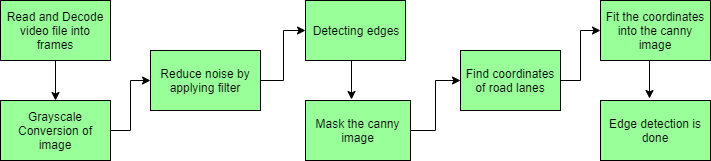

* Capturing and decoding video file: We will capture the video using VideoFileClip object and after the capturing has been initialized every video frame is decoded (i.e. converting into a sequence of images).<br>
* Grayscale conversion of image: The video frames are in RGB format, RGB is converted to grayscale because processing a single channel image is faster than processing a three-channel colored image.<br>
* Reduce noise: Noise can create false edges, therefore before going further, it’s imperative to perform image smoothening. Gaussian blur is used to perform this process. Gaussian blur is a typical image filtering technique for lowering noise and enhancing image characteristics. The weights are selected using a Gaussian distribution, and each pixel is subjected to a weighted average that considers the pixels surrounding it. By reducing high-frequency elements and improving overall image quality, this blurring technique creates softer, more visually pleasant images.<br>
* Canny Edge Detector: It computes gradient in all directions of our blurred image and traces the edges with large changes in intensity. For more explanation please go through this article: Canny Edge Detector
* Region of Interest: This step is to take into account only the region covered by the road lane. A mask is created here, which is of the same dimension as our road image. Furthermore, bitwise AND operation is performed between each pixel of our canny image and this mask. It ultimately masks the canny image and shows the region of interest traced by the polygonal contour of the mask.<br>
* Hough Line Transform: In image processing, the Hough transformation is a feature extraction method used to find basic geometric objects like lines and circles. By converting the picture space into a parameter space, it makes it possible to identify shapes by accumulating voting points. We’ll use the probabilistic Hough Line Transform in our algorithm. The Hough transformation has been extended to address the computational complexity with the probabilistic Hough transformation. In order to speed up processing while preserving accuracy in shape detection, it randomly chooses a selection of picture points and applies the Hough transformation solely to those points.<br></br>
Draw lines on the Image or Video: After identifying lane lines in our field of interest using Hough Line Transform, we overlay them on our visual input(video stream/image). <br>
Dataset: To demonstrate the working of this algorithm we will be working on a video file of a road. You can download the dataset from this GitHub link – Dataset